# CompMech04-Linear Algebra Project
## Practical Linear Algebra for Finite Element Analysis

In this project we will perform a linear-elastic finite element analysis (FEA) on a support structure made of 11 beams that are riveted in 7 locations to create a truss as shown in the image below. 

![Mesh image of truss](../images/mesh.png)

The triangular truss shown above can be modeled using a [direct stiffness method [1]](https://en.wikipedia.org/wiki/Direct_stiffness_method), that is detailed in the [extra-FEA_material](./extra-FEA_material.ipynb) notebook. The end result of converting this structure to a FE model. Is that each joint, labeled $n~1-7$, short for _node 1-7_ can move in the x- and y-directions, but causes a force modeled with Hooke's law. Each beam labeled $el~1-11$, short for _element 1-11_, contributes to the stiffness of the structure. We have 14 equations where the sum of the components of forces = 0, represented by the equation

$\mathbf{F-Ku}=\mathbf{0}$

Where, $\mathbf{F}$ are externally applied forces, $\mathbf{u}$ are x- and y- displacements of nodes, and $\mathbf{K}$ is the stiffness matrix given in `fea_arrays.npz` as `K`, shown below

_note: the array shown is 1000x(`K`). You can use units of MPa (N/mm^2), N, and mm. The array `K` is in 1/mm_

$\mathbf{K}=EA*$

$  \left[ \begin{array}{cccccccccccccc}
 4.2 & 1.4 & -0.8 & -1.4 & -3.3 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
 1.4 & 2.5 & -1.4 & -2.5 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
 -0.8 & -1.4 & 5.0 & 0.0 & -0.8 & 1.4 & -3.3 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
 -1.4 & -2.5 & 0.0 & 5.0 & 1.4 & -2.5 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
 -3.3 & 0.0 & -0.8 & 1.4 & 8.3 & 0.0 & -0.8 & -1.4 & -3.3 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
 0.0 & 0.0 & 1.4 & -2.5 & 0.0 & 5.0 & -1.4 & -2.5 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
 0.0 & 0.0 & -3.3 & 0.0 & -0.8 & -1.4 & 8.3 & 0.0 & -0.8 & 1.4 & -3.3 & 0.0 & 0.0 & 0.0 \\
 0.0 & 0.0 & 0.0 & 0.0 & -1.4 & -2.5 & 0.0 & 5.0 & 1.4 & -2.5 & 0.0 & 0.0 & 0.0 & 0.0 \\
 0.0 & 0.0 & 0.0 & 0.0 & -3.3 & 0.0 & -0.8 & 1.4 & 8.3 & 0.0 & -0.8 & -1.4 & -3.3 & 0.0 \\
 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 1.4 & -2.5 & 0.0 & 5.0 & -1.4 & -2.5 & 0.0 & 0.0 \\
 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & -3.3 & 0.0 & -0.8 & -1.4 & 5.0 & 0.0 & -0.8 & 1.4 \\
 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & -1.4 & -2.5 & 0.0 & 5.0 & 1.4 & -2.5 \\
 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & -3.3 & 0.0 & -0.8 & 1.4 & 4.2 & -1.4 \\
 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 1.4 & -2.5 & -1.4 & 2.5 \\
\end{array}\right]~\frac{1}{m}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import lu
from scipy.integrate import solve_ivp
plt.style.use('fivethirtyeight')

In [2]:
fea_arrays = np.load('./fea_arrays.npz')
K=fea_arrays['K']
K

array([[ 0.00416667,  0.00144338, -0.00083333, -0.00144338, -0.00333333,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.00144338,  0.0025    , -0.00144338, -0.0025    ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [-0.00083333, -0.00144338,  0.005     ,  0.        , -0.00083333,
         0.00144338, -0.00333333,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [-0.00144338, -0.0025    ,  0.        ,  0.005     ,  0.00144338,
        -0.0025    ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [-0.00333333,  0.        , -0.00083333,  0.00144338,  0.00833333,
         0.        , -0.00083333, -0.00144338, -0.00333333,  0.        ,
         0.        ,  0.  

In this project we are solving the problem, $\mathbf{F}=\mathbf{Ku}$, where $\mathbf{F}$ is measured in Newtons, $\mathbf{K}$ `=E*A*K` is the stiffness in N/mm, `E` is Young's modulus measured in MPa (N/mm^2), and `A` is the cross-sectional area of the beam measured in mm^2. 

There are three constraints on the motion of the joints:

i. node 1 displacement in the x-direction is 0 = `u[0]`

ii. node 1 displacement in the y-direction is 0 = `u[1]`

iii. node 7 displacement in the y-direction is 0 = `u[13]`

We can satisfy these constraints by leaving out the first, second, and last rows and columns from our linear algebra description.

### 1. Calculate the condition of `K` and the condition of `K[2:13,2:13]`. 

a. What error would you expect when you solve for `u` in `K*u = F`? 

b. Why is the condition of `K` so large? __The problem is underconstrained. It describes stiffness of structure, but not the BC's. So, we end up with sumF=0 and -sumF=0__

c. What error would you expect when you solve for `u[2:13]` in `K[2:13,2:13]*u=F[2:13]`

In [3]:
print(np.linalg.cond(K))
print(np.linalg.cond(K[2:13,2:13]))

#part a and c
print('expected error in x=solve(K,b) is {}'.format(10**(17-16)))
print('expected error in x=solve(K[2:13,2:13],b) is {}'.format(10**(1-16)))

1.4577532625238035e+17
52.23542514351006
expected error in x=solve(K,b) is 10
expected error in x=solve(K[2:13,2:13],b) is 1e-15


Part b: K is large because the problem is underconstrained. It describes stiffness of structure, but not the BC's. So, we end up with sumF=0 and -sumF=0.

### 2. Apply a 300-N downward force to the central top node (n 4)

a. Create the LU matrix for K[2:13,2:13]

b. Use cross-sectional area of $0.1~mm^2$ and steel and almuminum moduli, $E=200~GPa~and~E=70~GPa,$ respectively. Solve the forward and backward substitution methods for 

* $\mathbf{Ly}=\mathbf{F}\frac{1}{EA}$

* $\mathbf{Uu}=\mathbf{y}$

_your array `F` is zeros, except for `F[5]=-300`, to create a -300 N load at node 4._

c. Plug in the values for $\mathbf{u}$ into the full equation, $\mathbf{Ku}=\mathbf{F}$, to solve for the reaction forces

d. Create a plot of the undeformed and deformed structure with the displacements and forces plotted as vectors (via `quiver`). Your result for aluminum should match the following result from [extra-FEA_material](./extra-FEA_material.ipynb). _note: The scale factor is applied to displacements $\mathbf{u}$, not forces._

> __Note__: Look at the [extra FEA material](./extra-FEA_material). It
> has example code that you can plug in here to make these plots.
> Including background information and the source code for this plot
> below.


![Deformed structure with loads applied](../images/deformed_truss.png)

In [4]:
#part a
K1 = K[2:13,2:13]
P, L, U= lu(K1)

E_st = 200e3
E_al = 70e3
A = 0.1
F= np.zeros(len(L))
F[5]= -300
F_st = F/(E_st*A)
F_al = F/(E_al*A)

#part b
u1=np.zeros(14)
u2=np.zeros(14)

y_st = np.linalg.solve(L, F_st)
u_st = np.linalg.solve(U, y_st)
u1[2:13]=u_st

y_al = np.linalg.solve(L, F_al)
u_al = np.linalg.solve(U, y_al)
u2[2:13]=u_al

#part c
F_st1 = E_st*A*K@u1
F_al1 = E_al*A*K@u2

In [5]:
xy_st={0:'x',1:'y'}
xy_al={0:'x',1:'y'}
print('displacements steel:\n----------------')
for i in range(len(u1)):
    print('u_{}{}:{:.2f} mm'.format(int(i/2)+1,xy_st[i%2],u1[i]))
print('\nforces steel:\n----------------')
for i in range(len(F_st1)):
    print('F_{}{}:{:.2f} N'.format(int(i/2)+1,xy_st[i%2],F_st1[i]))
    
    
print('\ndisplacements aluminum:\n----------------')
for i in range(len(u2)):
    print('u_{}{}:{:.2f} mm'.format(int(i/2)+1,xy_al[i%2],u2[i]))
print('\nforces aluminum:\n----------------')
for i in range(len(F_st1)):
    print('F_{}{}:{:.2f} N'.format(int(i/2)+1,xy_al[i%2],F_al1[i]))

displacements steel:
----------------
u_1x:0.00 mm
u_1y:0.00 mm
u_2x:5.85 mm
u_2y:-6.37 mm
u_3x:1.30 mm
u_3y:-12.00 mm
u_4x:3.25 mm
u_4y:-16.12 mm
u_5x:5.20 mm
u_5y:-12.00 mm
u_6x:0.65 mm
u_6y:-6.37 mm
u_7x:6.50 mm
u_7y:0.00 mm

forces steel:
----------------
F_1x:-0.00 N
F_1y:150.00 N
F_2x:0.00 N
F_2y:0.00 N
F_3x:0.00 N
F_3y:-0.00 N
F_4x:-0.00 N
F_4y:-300.00 N
F_5x:-0.00 N
F_5y:-0.00 N
F_6x:0.00 N
F_6y:0.00 N
F_7x:-0.00 N
F_7y:150.00 N

displacements aluminum:
----------------
u_1x:0.00 mm
u_1y:0.00 mm
u_2x:16.70 mm
u_2y:-18.21 mm
u_3x:3.71 mm
u_3y:-34.29 mm
u_4x:9.28 mm
u_4y:-46.07 mm
u_5x:14.85 mm
u_5y:-34.29 mm
u_6x:1.86 mm
u_6y:-18.21 mm
u_7x:18.56 mm
u_7y:0.00 mm

forces aluminum:
----------------
F_1x:-0.00 N
F_1y:150.00 N
F_2x:-0.00 N
F_2y:0.00 N
F_3x:0.00 N
F_3y:-0.00 N
F_4x:-0.00 N
F_4y:-300.00 N
F_5x:0.00 N
F_5y:-0.00 N
F_6x:-0.00 N
F_6y:0.00 N
F_7x:0.00 N
F_7y:150.00 N


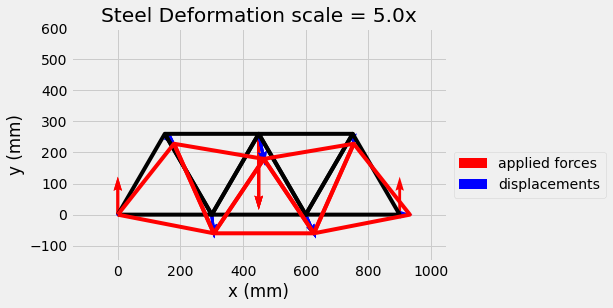

In [6]:
#part d
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

l=300 # mm
nodes = np.array([[1,0,0],[2,0.5,3**0.5/2],[3,1,0],[4,1.5,3**0.5/2],[5,2,0],[6,2.5,3**0.5/2],[7,3,0]])
nodes[:,1:3]*=l
elems = np.array([[1,1,2],[2,2,3],[3,1,3],[4,2,4],[5,3,4],[6,3,5],[7,4,5],[8,4,6],[9,5,6],[10,5,7],[11,6,7]])

ix = 2*np.block([[np.arange(0,5)],[np.arange(1,6)],[np.arange(2,7)],[np.arange(0,5)]])
iy = ix+1

r = np.block([n[1:3] for n in nodes])

def f(s,x):
    if x ==1:
        plt.plot(r[ix],r[iy],'-',color=(0,0,0,1))
        plt.plot(r[ix]+u1[ix]*s,r[iy]+u1[iy]*s,'-',color=(1,0,0,1))
        #plt.quiver(r[ix],r[iy],u[ix],u[iy],color=(0,0,1,1),label='displacements')
        plt.quiver(r[ix],r[iy],F_st1[ix],F_st1[iy],color=(1,0,0,1),label='applied forces')
        plt.quiver(r[ix],r[iy],u1[ix],u1[iy],color=(0,0,1,1),label='displacements')
        plt.axis(l*np.array([-0.5,3.5,-0.5,2]))
        plt.xlabel('x (mm)')
        plt.ylabel('y (mm)')
        plt.title('Steel Deformation scale = {:.1f}x'.format(s))
        plt.legend(bbox_to_anchor=(1,0.5))
    else:
        plt.plot(r[ix],r[iy],'-',color=(0,0,0,1))
        plt.plot(r[ix]+u2[ix]*s,r[iy]+u2[iy]*s,'-',color=(1,0,0,1))
        #plt.quiver(r[ix],r[iy],u[ix],u[iy],color=(0,0,1,1),label='displacements')
        plt.quiver(r[ix],r[iy],F_al1[ix],F_al1[iy],color=(1,0,0,1),label='applied forces')
        plt.quiver(r[ix],r[iy],u2[ix],u2[iy],color=(0,0,1,1),label='displacements')
        plt.axis(l*np.array([-0.5,3.5,-0.5,2]))
        plt.xlabel('x (mm)')
        plt.ylabel('y (mm)')
        plt.title('Aluminum Deformation scale = {:.1f}x'.format(s))
        plt.legend(bbox_to_anchor=(1,0.5))

f(5,1)

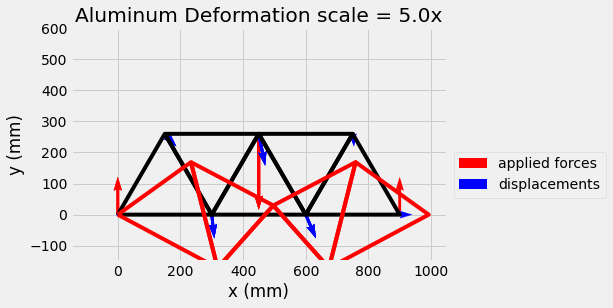

In [7]:
f(5,2)

### 3. Determine cross-sectional area

a. Using aluminum, what is the minimum cross-sectional area to keep total y-deflections $<0.2~mm$?

b. Using steel, what is the minimum cross-sectional area to keep total y-deflections $<0.2~mm$?

c. What are the weights of the aluminum and steel trusses with the
chosen cross-sectional areas?

In [8]:
#part a
def steel_deflec(Area):
    A = Area
    E=200e3
    Ff=np.zeros(2*len(nodes)-3)
    Ff[5]=-300
    # step 1 solve for uf (the joints without constraints)
    uf = np.linalg.solve(E*A*K[2:13,2:13],Ff)
    u=np.zeros(2*len(nodes))
    u[2:13]=uf
    y_deflect = np.max(np.abs(u[1::2]))
    error = .2 - y_deflect
    return error

def aluminum_deflec(Area):
    A = Area
    E=70e3
    Ff=np.zeros(2*len(nodes)-3)
    Ff[5]=-300
    # step 1 solve for uf (the joints without constraints)
    uf = np.linalg.solve(E*A*K[2:13,2:13],Ff)
    u=np.zeros(2*len(nodes))
    u[2:13]=uf
    y_deflect = np.max(np.abs(u[1::2]))
    error = .2 - y_deflect
    return error

In [9]:
def mod_secant(func,dx,x0,es=0.0001,maxit=50):
    '''mod_secant: Modified secant root location zeroes
    root,[fx,ea,iter]=mod_secant(func,dfunc,xr,es,maxit,p1,p2,...):
    uses modified secant method to find the root of func
    arguments:
    ----------
    func = name of function
    dx = perturbation fraction
    xr = initial guess
    es = desired relative error (default = 0.0001 )
    maxit = maximum allowable iterations (default = 50)
    p1,p2,... = additional parameters used by function
    returns:
    --------
    root = real root
    fx = func evaluated at root
    ea = approximate relative error ( )
    iter = number of iterations'''

    iter = 0;
    xr=x0
    for iter in range(0,maxit):
        xrold = xr;
        dfunc=(func(xr+dx)-func(xr))/dx;
        xr = xr - func(xr)/dfunc;
        if xr != 0:
            ea = abs((xr - xrold)/xr) * 100;
        else:
            ea = abs((xr - xrold)/1) * 100;
        if ea <= es:
            break
    return xr,[func(xr),ea,iter]

In [10]:
#part a and b
step_size = .00001
a = np.linspace(0,2,100,endpoint=False)
err_modsec1=np.zeros(len(a))
err_modsec2=np.zeros(len(a))

root1,out1 = mod_secant(steel_deflec,step_size,.1,es=0)
    
root2,out2 = mod_secant(aluminum_deflec,step_size,.1,es=0)

print('Steel minimum cross-sectional area: {:.1f} mm^2'.format(root1))
print('Aluminum minimum cross-sectional area: {:.1f} mm^2'.format(root2))

Steel minimum cross-sectional area: 8.1 mm^2
Aluminum minimum cross-sectional area: 23.0 mm^2


In [11]:
rho_st = 0.00805 #g/mm^3
rho_al = 0.0027 #g/mm^3
g = 9.81
n = 11
v_st = root1*n*l
v_al = root2*n*l

st_weight = v_st*rho_st*g/1000
al_weight = v_al*rho_al*g/1000

print('Weight of steel truss: {:.1f} Newtons'.format(st_weight))
print('Weight of aluminum truss: {:.1f} Newtons'.format(al_weight))

Weight of steel truss: 2.1 Newtons
Weight of aluminum truss: 2.0 Newtons


## References

1. <https://en.wikipedia.org/wiki/Direct_stiffness_method>